In [ ]:
!pip install selenium

In [4]:
!pip install webdriver_manager

In [ ]:
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

# ----------------------------------------
# Helper to slow scroll page
# ----------------------------------------
def slow_scroll(driver, step=400, wait=0.6):
    last_height = driver.execute_script("return document.body.scrollHeight")
    current = 0
    while current < last_height:
        driver.execute_script(f"window.scrollTo(0, {current});")
        time.sleep(wait)
        current += step
        last_height = driver.execute_script("return document.body.scrollHeight")

# ----------------------------------------
# Extract basic details (top block)
# ----------------------------------------
def extract_basic_info(card):
    # Airline + Flight number are together in .airline-name
    try:
        name_block = card.find_element(By.CSS_SELECTOR, ".airline-name")
        lines = name_block.text.split("\n")
        airline = lines[0].strip() if len(lines) >= 1 else "Not Available"
        flight_no = lines[1].strip() if len(lines) >= 2 else "Not Available"
    except:
        airline = "Not Available"
        flight_no = "Not Available"

    try:
        dep_city = card.find_element(
            By.CSS_SELECTOR, ".depart-details p.fs-16"
        ).text.strip()
    except:
        dep_city = "Not Available"

    try:
        dep_time = card.find_element(
            By.CSS_SELECTOR, ".depart-details p.fs-20"
        ).text.strip()
    except:
        dep_time = "Not Available"

    try:
        arr_city = card.find_element(
            By.CSS_SELECTOR, ".arrival-details p.fs-16"
        ).text.strip()
    except:
        arr_city = "Not Available"

    try:
        arr_time = card.find_element(
            By.CSS_SELECTOR, ".arrival-details p.fs-20"
        ).text.strip()
    except:
        arr_time = "Not Available"

    try:
        duration = card.find_element(
            By.CSS_SELECTOR, ".mob-duration"
        ).text.strip()
    except:
        duration = "Not Available"

    try:
        stops = card.find_element(
            By.CSS_SELECTOR, ".flight-trace span"
        ).text.strip()
    except:
        stops = "Not Available"

    return airline, flight_no, dep_city, dep_time, arr_city, arr_time, duration, stops

# ----------------------------------------
# Extract fare-level data (Value / Classic / Flex)
# ----------------------------------------
def extract_fare_block(block):
    # Price
    try:
        price_text = block.find_element(
            By.CSS_SELECTOR, "p.fare-price"
        ).text.strip()
        # Remove currency symbol and commas -> keep only digits
        fare_price = (
            price_text.replace("₹", "").replace(",", "").strip()
        )
    except:
        fare_price = "Not Available"

    # Default service values
    svc = {
        "Cancellation": "No",           # Yes/No
        "Date Change": "No",            # Yes/No
        "Seat Selection": "Not Available",
        "Checked Baggage": "Not Available",
        "Hand Baggage": "Not Available",
        "Meal": "Not Available",
    }

    # Each li inside fare-feature-list has a class that tells the type:
    # cf-2 = cancellation, rf-2 = date change, ss-2 = seat selection,
    # bg-1 = checked bag, hb-1 = hand bag, ml-1 = meal
    features = block.find_elements(By.CSS_SELECTOR, "ul.fare-feature-list li")

    for li in features:
        cls = li.get_attribute("class") or ""
        cls = cls.lower()
        text = li.text.strip()

        if "cf-" in cls:                  # cancellation
            svc["Cancellation"] = "Yes"
        elif "rf-" in cls:                # date change
            svc["Date Change"] = "Yes"
        elif "ss-" in cls:                # seat selection
            svc["Seat Selection"] = text
        elif "bg-" in cls:                # checked baggage
            svc["Checked Baggage"] = text
        elif "hb-" in cls:                # hand baggage
            svc["Hand Baggage"] = text
        elif "ml-" in cls:                # meal
            svc["Meal"] = text

    return fare_price, svc

# ----------------------------------------
# Start scraping
# ----------------------------------------
def main():

    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    driver.maximize_window()

    # -------------------------
    # STEP 1 — open Yatra.com
    # -------------------------
    driver.get("https://www.yatra.com")

    print("\n👉 Fill FROM, TO, DATE manually")
    print("👉 Then click SEARCH")
    print("👉 After results load, return here and press ENTER")
    input("Press ENTER after the results page is fully loaded... ")

    print("\n⏳ Scrolling page...")
    slow_scroll(driver)

    print("⏳ Collecting flight cards...")
    cards = driver.find_elements(By.CSS_SELECTOR, ".flightItem")

    print(f"🔍 Found {len(cards)} flights")

    rows = []

    # Loop through each flight card
    for idx, card in enumerate(cards, start=1):
        print(f"🔄 Processing flight {idx}/{len(cards)}")

        # Make sure "View Details" is expanded
        try:
            # If it's already "Hide Details", no issue – click is safe
            view_btn = card.find_element(
                By.XPATH,
                ".//span[contains(text(),'View Details') or contains(text(),'Hide Details')]"
            )
            driver.execute_script("arguments[0].click();", view_btn)
            time.sleep(1.0)
        except:
            pass

        # Basic info
        (
            airline,
            flight_no,
            dep_city,
            dep_time,
            arr_city,
            arr_time,
            duration,
            stops,
        ) = extract_basic_info(card)

        # Fare blocks (Saver, Flexi, Super 6E etc.)
        try:
            fare_blocks = card.find_elements(By.CSS_SELECTOR, ".br-fare-block")
        except:
            fare_blocks = []

        for fb in fare_blocks:
            # fare type text, e.g. "Saver Fare", "Flexi Plus", "Super 6E"
            try:
                fare_type = fb.find_element(
                    By.CSS_SELECTOR, ".fare-title"
                ).text.strip()
            except:
                fare_type = "Unknown"

            fare_price, svc = extract_fare_block(fb)

            # Save row  (one row per fare type – Option B)
            rows.append(
                {
                    "Airline": airline,
                    "Flight Number": flight_no,
                    "Departure City": dep_city,
                    "Departure Time": dep_time,
                    "Arrival City": arr_city,
                    "Arrival Time": arr_time,
                    "Duration": duration,
                    "Stops": stops,
                    "Fare Type": fare_type,
                    "Fare Price": fare_price,  # numeric string
                    "Cancellation Policy": svc["Cancellation"],  # Yes/No
                    "Date Change Policy": svc["Date Change"],   # Yes/No
                    "Seat Selection": svc["Seat Selection"],
                    "Checked Baggage": svc["Checked Baggage"],
                    "Hand Baggage": svc["Hand Baggage"],
                    "Meal": svc["Meal"],
                    "Scraped At": pd.Timestamp.now(),
                }
            )

    data = pd.DataFrame(rows)

    out_file = "yatra_flights_optionB_clean_fixed.csv"
    data.to_csv(out_file, index=False)

    print("\n✅ DONE! Saved:", out_file)
    print(data.head())

    driver.quit()


if __name__ == "__main__":
    main()

In [3]:
import pandas as pd
flight_data = pd.read_csv(rf"C:\Users\shiva kumar\Downloads\flights data.xls")
flight_data

,Airline,Flight Number,Departure City,Departure Time,Arrival City,Arrival Time,Duration,Stops,Fare Type,Fare Price,Cancellation Policy,Date Change Policy,Seat Selection,Checked Baggage,Hand Baggage,Meal,Scraped At
0,Akasa Air,QP-1407,Hyderabad(HYD),17:40,New Delhi(DEL),20:00,2h 20m,Not Available,Saver Fare,7479,Yes,Yes,NaN,NaN,NaN,NaN,2025-11-26 16:12:49.109774
1,Akasa Air,QP-1407,Hyderabad(HYD),17:40,New Delhi(DEL),20:00,2h 20m,Not Available,Flexi Fare,7996,Yes,Yes,NaN,NaN,NaN,NaN,2025-11-26 16:12:49.224293
2,IndiGo,6E-849,Hyderabad(HYD),15:15,New Delhi(DEL),17:50,2h 35m,Not Available,Saver Fare,8009,Yes,Yes,Standard: Chargeable\nXL seats: Chargeable,15 Kgs,7 Kgs,Chargeable,2025-11-26 16:12:50.602275
3,IndiGo,6E-849,Hyderabad(HYD),15:15,New Delhi(DEL),17:50,2h 35m,Not Available,Flexi Plus,8534,Yes,Yes,Standard: FREE\nXL seats: Chargeable,15 Kgs,7 Kgs,Complimentary,2025-11-26 16:12:50.737100
4,IndiGo,6E-849,Hyderabad(HYD),15:15,New Delhi(DEL),17:50,2h 35m,Not Available,Super 6E,9584,Yes,Yes,Standard: FREE\nXL seats: FREE,20 Kg,7 Kgs,Complimentary,2025-11-26 16:12:50.863631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,AirIndia Express,IX-2941/IX-1970,Hyderabad(HYD),20:00,Ghaziabad(HDO),08:15,12h 15m,Not Available,Unknown,Not Available,No,No,Not Available,Not Available,Not Available,Not Available,2025-11-26 16:16:04.484747
546,AirIndia Express,IX-1072/IX-1970,Hyderabad(HYD),22:15,Ghaziabad(HDO),08:15,10h 00m,Not Available,Value,21864,Yes,Yes,Standard: Chargeable\nPrime: Chargeable,15 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Chargeable,2025-11-26 16:16:05.848395
547,AirIndia Express,IX-1072/IX-1970,Hyderabad(HYD),22:15,Ghaziabad(HDO),08:15,10h 00m,Not Available,Classic,22284,Yes,Yes,Standard: Chargeable\nPrime: Chargeable,15 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Free,2025-11-26 16:16:05.937414
548,AirIndia Express,IX-1072/IX-1970,Hyderabad(HYD),22:15,Ghaziabad(HDO),08:15,10h 00m,Not Available,Flex,24698,Yes,Yes,Standard: Chargeable\nPrime: Chargeable,20 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Free,2025-11-26 16:16:06.027401


In [4]:
flight_data.isna().sum()

Airline                0
Flight Number          0
Departure City         0
Departure Time         0
Arrival City           0
Arrival Time           0
Duration               0
Stops                  0
Fare Type              0
Fare Price             0
Cancellation Policy    0
Date Change Policy     0
Seat Selection         2
Checked Baggage        2
Hand Baggage           2
Meal                   2
Scraped At             0
dtype: int64

In [5]:
flight_data.duplicated().sum()

np.int64(0)

In [6]:
flight_data = flight_data[flight_data['Fare Type'] != 'Unknown']
flight_data

,Airline,Flight Number,Departure City,Departure Time,Arrival City,Arrival Time,Duration,Stops,Fare Type,Fare Price,Cancellation Policy,Date Change Policy,Seat Selection,Checked Baggage,Hand Baggage,Meal,Scraped At
0,Akasa Air,QP-1407,Hyderabad(HYD),17:40,New Delhi(DEL),20:00,2h 20m,Not Available,Saver Fare,7479,Yes,Yes,NaN,NaN,NaN,NaN,2025-11-26 16:12:49.109774
1,Akasa Air,QP-1407,Hyderabad(HYD),17:40,New Delhi(DEL),20:00,2h 20m,Not Available,Flexi Fare,7996,Yes,Yes,NaN,NaN,NaN,NaN,2025-11-26 16:12:49.224293
2,IndiGo,6E-849,Hyderabad(HYD),15:15,New Delhi(DEL),17:50,2h 35m,Not Available,Saver Fare,8009,Yes,Yes,Standard: Chargeable\nXL seats: Chargeable,15 Kgs,7 Kgs,Chargeable,2025-11-26 16:12:50.602275
3,IndiGo,6E-849,Hyderabad(HYD),15:15,New Delhi(DEL),17:50,2h 35m,Not Available,Flexi Plus,8534,Yes,Yes,Standard: FREE\nXL seats: Chargeable,15 Kgs,7 Kgs,Complimentary,2025-11-26 16:12:50.737100
4,IndiGo,6E-849,Hyderabad(HYD),15:15,New Delhi(DEL),17:50,2h 35m,Not Available,Super 6E,9584,Yes,Yes,Standard: FREE\nXL seats: FREE,20 Kg,7 Kgs,Complimentary,2025-11-26 16:12:50.863631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,AirIndia Express,IX-2941/IX-1970,Hyderabad(HYD),20:00,Ghaziabad(HDO),08:15,12h 15m,Not Available,Classic,17981,Yes,Yes,Standard: Chargeable\nPrime: Chargeable,15 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Free,2025-11-26 16:16:04.344718
544,AirIndia Express,IX-2941/IX-1970,Hyderabad(HYD),20:00,Ghaziabad(HDO),08:15,12h 15m,Not Available,Flex,18821,Yes,Yes,Standard: Chargeable\nPrime: Chargeable,20 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Free,2025-11-26 16:16:04.464252
546,AirIndia Express,IX-1072/IX-1970,Hyderabad(HYD),22:15,Ghaziabad(HDO),08:15,10h 00m,Not Available,Value,21864,Yes,Yes,Standard: Chargeable\nPrime: Chargeable,15 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Chargeable,2025-11-26 16:16:05.848395
547,AirIndia Express,IX-1072/IX-1970,Hyderabad(HYD),22:15,Ghaziabad(HDO),08:15,10h 00m,Not Available,Classic,22284,Yes,Yes,Standard: Chargeable\nPrime: Chargeable,15 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Free,2025-11-26 16:16:05.937414


In [7]:
flight_data = flight_data.drop('Scraped At',axis = 1)
flight_data

,Airline,Flight Number,Departure City,Departure Time,Arrival City,Arrival Time,Duration,Stops,Fare Type,Fare Price,Cancellation Policy,Date Change Policy,Seat Selection,Checked Baggage,Hand Baggage,Meal
0,Akasa Air,QP-1407,Hyderabad(HYD),17:40,New Delhi(DEL),20:00,2h 20m,Not Available,Saver Fare,7479,Yes,Yes,NaN,NaN,NaN,NaN
1,Akasa Air,QP-1407,Hyderabad(HYD),17:40,New Delhi(DEL),20:00,2h 20m,Not Available,Flexi Fare,7996,Yes,Yes,NaN,NaN,NaN,NaN
2,IndiGo,6E-849,Hyderabad(HYD),15:15,New Delhi(DEL),17:50,2h 35m,Not Available,Saver Fare,8009,Yes,Yes,Standard: Chargeable\nXL seats: Chargeable,15 Kgs,7 Kgs,Chargeable
3,IndiGo,6E-849,Hyderabad(HYD),15:15,New Delhi(DEL),17:50,2h 35m,Not Available,Flexi Plus,8534,Yes,Yes,Standard: FREE\nXL seats: Chargeable,15 Kgs,7 Kgs,Complimentary
4,IndiGo,6E-849,Hyderabad(HYD),15:15,New Delhi(DEL),17:50,2h 35m,Not Available,Super 6E,9584,Yes,Yes,Standard: FREE\nXL seats: FREE,20 Kg,7 Kgs,Complimentary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,AirIndia Express,IX-2941/IX-1970,Hyderabad(HYD),20:00,Ghaziabad(HDO),08:15,12h 15m,Not Available,Classic,17981,Yes,Yes,Standard: Chargeable\nPrime: Chargeable,15 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Free
544,AirIndia Express,IX-2941/IX-1970,Hyderabad(HYD),20:00,Ghaziabad(HDO),08:15,12h 15m,Not Available,Flex,18821,Yes,Yes,Standard: Chargeable\nPrime: Chargeable,20 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Free
546,AirIndia Express,IX-1072/IX-1970,Hyderabad(HYD),22:15,Ghaziabad(HDO),08:15,10h 00m,Not Available,Value,21864,Yes,Yes,Standard: Chargeable\nPrime: Chargeable,15 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Chargeable
547,AirIndia Express,IX-1072/IX-1970,Hyderabad(HYD),22:15,Ghaziabad(HDO),08:15,10h 00m,Not Available,Classic,22284,Yes,Yes,Standard: Chargeable\nPrime: Chargeable,15 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Free


In [8]:
flight_data = flight_data.dropna()

In [9]:
flight_data

,Airline,Flight Number,Departure City,Departure Time,Arrival City,Arrival Time,Duration,Stops,Fare Type,Fare Price,Cancellation Policy,Date Change Policy,Seat Selection,Checked Baggage,Hand Baggage,Meal
2,IndiGo,6E-849,Hyderabad(HYD),15:15,New Delhi(DEL),17:50,2h 35m,Not Available,Saver Fare,8009,Yes,Yes,Standard: Chargeable\nXL seats: Chargeable,15 Kgs,7 Kgs,Chargeable
3,IndiGo,6E-849,Hyderabad(HYD),15:15,New Delhi(DEL),17:50,2h 35m,Not Available,Flexi Plus,8534,Yes,Yes,Standard: FREE\nXL seats: Chargeable,15 Kgs,7 Kgs,Complimentary
4,IndiGo,6E-849,Hyderabad(HYD),15:15,New Delhi(DEL),17:50,2h 35m,Not Available,Super 6E,9584,Yes,Yes,Standard: FREE\nXL seats: FREE,20 Kg,7 Kgs,Complimentary
6,IndiGo,6E-962,Hyderabad(HYD),17:00,New Delhi(DEL),19:20,2h 20m,Not Available,Saver Fare,8009,Yes,Yes,Standard: Chargeable\nXL seats: Chargeable,15 Kgs,7 Kgs,Chargeable
7,IndiGo,6E-962,Hyderabad(HYD),17:00,New Delhi(DEL),19:20,2h 20m,Not Available,Flexi Plus,8534,Yes,Yes,Standard: FREE\nXL seats: Chargeable,15 Kgs,7 Kgs,Complimentary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,AirIndia Express,IX-2941/IX-1970,Hyderabad(HYD),20:00,Ghaziabad(HDO),08:15,12h 15m,Not Available,Classic,17981,Yes,Yes,Standard: Chargeable\nPrime: Chargeable,15 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Free
544,AirIndia Express,IX-2941/IX-1970,Hyderabad(HYD),20:00,Ghaziabad(HDO),08:15,12h 15m,Not Available,Flex,18821,Yes,Yes,Standard: Chargeable\nPrime: Chargeable,20 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Free
546,AirIndia Express,IX-1072/IX-1970,Hyderabad(HYD),22:15,Ghaziabad(HDO),08:15,10h 00m,Not Available,Value,21864,Yes,Yes,Standard: Chargeable\nPrime: Chargeable,15 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Chargeable
547,AirIndia Express,IX-1072/IX-1970,Hyderabad(HYD),22:15,Ghaziabad(HDO),08:15,10h 00m,Not Available,Classic,22284,Yes,Yes,Standard: Chargeable\nPrime: Chargeable,15 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Free


In [10]:
flight_data['Airline'].value_counts()

Airline
Air India           225
IndiGo              123
AirIndia Express     57
SpiceJet              2
Name: count, dtype: int64

In [11]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 407 entries, 2 to 548
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Airline              407 non-null    object
 1   Flight Number        407 non-null    object
 2   Departure City       407 non-null    object
 3   Departure Time       407 non-null    object
 4   Arrival City         407 non-null    object
 5   Arrival Time         407 non-null    object
 6   Duration             407 non-null    object
 7   Stops                407 non-null    object
 8   Fare Type            407 non-null    object
 9   Fare Price           407 non-null    object
 10  Cancellation Policy  407 non-null    object
 11  Date Change Policy   407 non-null    object
 12  Seat Selection       407 non-null    object
 13  Checked Baggage      407 non-null    object
 14  Hand Baggage         407 non-null    object
 15  Meal                 407 non-null    object
dtypes: object(16)

In [12]:
flight_data.columns

Index(['Airline', 'Flight Number', 'Departure City', 'Departure Time',
       'Arrival City', 'Arrival Time', 'Duration', 'Stops', 'Fare Type',
       'Fare Price', 'Cancellation Policy', 'Date Change Policy',
       'Seat Selection', 'Checked Baggage', 'Hand Baggage', 'Meal'],
      dtype='object')

In [13]:
flight_data.shape

(407, 16)

In [15]:

# categorical / string
flight_data['Airline']              = flight_data['Airline'].astype('category')
flight_data['Flight Number']        = flight_data['Flight Number'].astype('string')
flight_data['Departure City']       = flight_data['Departure City'].astype('category')
flight_data['Arrival City']         = flight_data['Arrival City'].astype('category')
flight_data['Stops']                = flight_data['Stops'].astype('category')
flight_data['Fare Type']            = flight_data['Fare Type'].astype('category')
flight_data['Cancellation Policy']  = flight_data['Cancellation Policy'].astype('category')
flight_data['Date Change Policy']   = flight_data['Date Change Policy'].astype('category')
flight_data['Seat Selection']       = flight_data['Seat Selection'].astype('category')
flight_data['Meal']                 = flight_data['Meal'].astype('category')

# numeric
flight_data['Fare Price']      = flight_data['Fare Price'].astype('float')


# date/time (only if parsable as dates/times)
flight_data['Departure Time']  = pd.to_datetime(flight_data['Departure Time'],errors = 'coerce')
flight_data['Arrival Time']    = pd.to_datetime(flight_data['Arrival Time'])


C:\Users\shiva kumar\AppData\Local\Temp\ipykernel_8212\206227939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data['Airline']              = flight_data['Airline'].astype('category')
C:\Users\shiva kumar\AppData\Local\Temp\ipykernel_8212\206227939.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data['Flight Number']        = flight_data['Flight Number'].astype('string')
C:\Users\shiva kumar\AppData\Local\Temp\ipykernel_8212\206227939.py:4: SettingWithCopyWarning: 
A value is trying 

In [58]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 407 entries, 2 to 548
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Airline              407 non-null    category      
 1   Flight Number        407 non-null    string        
 2   Departure City       407 non-null    category      
 3   Departure Time       407 non-null    datetime64[ns]
 4   Arrival City         407 non-null    category      
 5   Arrival Time         407 non-null    datetime64[ns]
 6   Duration             407 non-null    object        
 7   Stops                407 non-null    category      
 8   Fare Type            407 non-null    category      
 9   Fare Price           407 non-null    float64       
 10  Cancellation Policy  407 non-null    category      
 11  Date Change Policy   407 non-null    category      
 12  Seat Selection       407 non-null    category      
 13  Checked Baggage      407 non-null    obj

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

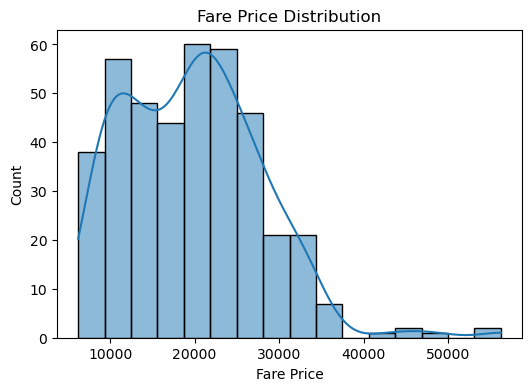

In [17]:
# 1)Univariate analysis
# Histogram of Fare Price
plt.figure(figsize=(6,4))
sns.histplot(flight_data['Fare Price'], kde=True)
plt.title('Fare Price Distribution')
plt.show()


#  Numeric vs numeric (e.g., Duration vs Fare Price)

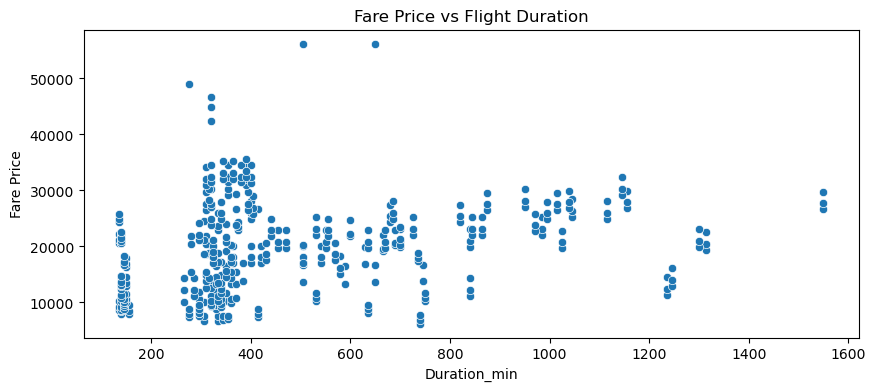

In [35]:
plt.figure(figsize=(10,4))
sns.scatterplot(data = flight_data, x= 'Duration_min', y = 'Fare Price')
plt.title('Fare Price vs Flight Duration')
plt.show()

# Categorical columns

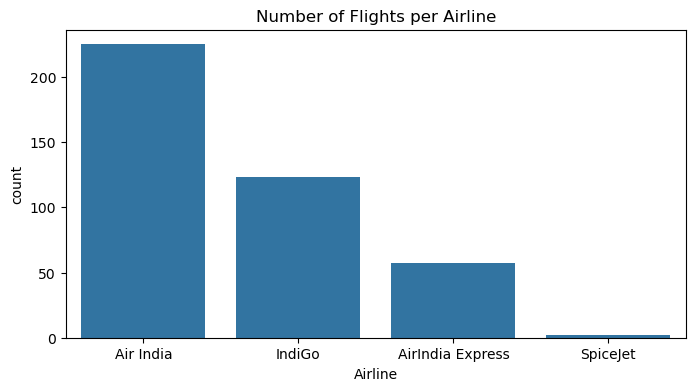

In [34]:
plt.figure(figsize = (8,4))
sns.countplot(data = flight_data, x = 'Airline', order = flight_data['Airline'].value_counts().index)
plt.title('Number of Flights per Airline')
plt.show()

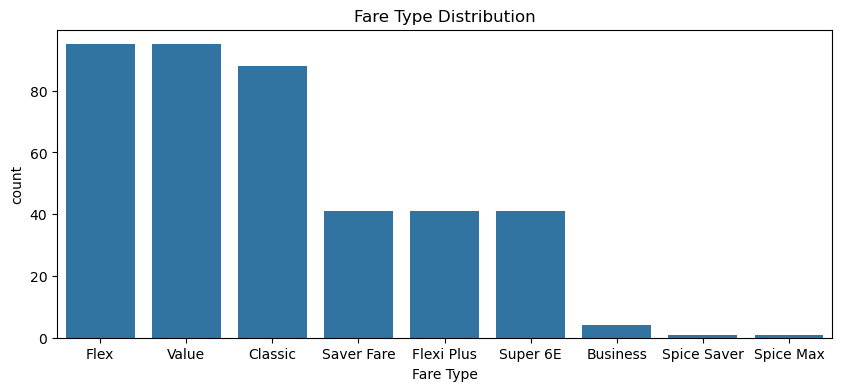

In [33]:
plt.figure(figsize = (10,4))
sns.countplot(data = flight_data, x = 'Fare Type', order = flight_data['Fare Type'].value_counts().index)
plt.title('Fare Type Distribution')
plt.show()

# Bivariate / multivariate analysis

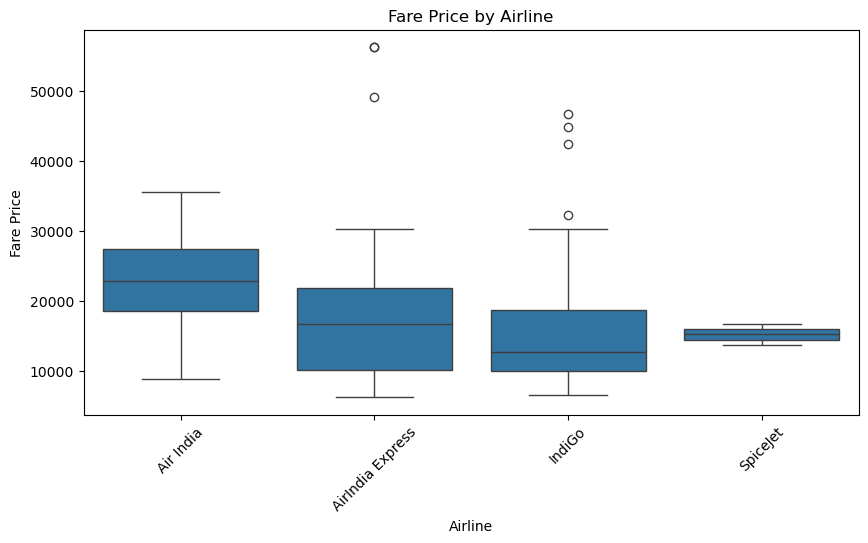

In [36]:
# . Category vs numeric (e.g., Airline vs Fare Price)
plt.figure(figsize = (10,5))
sns.boxplot(data = flight_data , x = 'Airline', y = 'Fare Price')
plt.xticks(rotation=45)
plt.title('Fare Price by Airline')
plt.show()

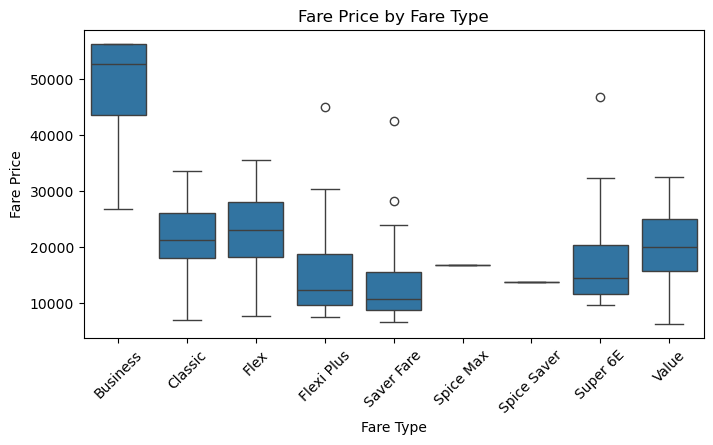

In [37]:
plt.figure(figsize=(8,4))
sns.boxplot(data=flight_data, x='Fare Type', y='Fare Price')
plt.xticks(rotation=45)
plt.title('Fare Price by Fare Type')
plt.show()

In [38]:
flight_data['Airline'].value_counts()

Airline
Air India           225
IndiGo              123
AirIndia Express     57
SpiceJet              2
Name: count, dtype: int64

In [39]:
flight_data['Fare Type'].value_counts()

Fare Type
Flex           95
Value          95
Classic        88
Saver Fare     41
Flexi Plus     41
Super 6E       41
Business        4
Spice Saver     1
Spice Max       1
Name: count, dtype: int64

In [40]:
flight_data['Stops'].value_counts()

Stops
Not Available    407
Name: count, dtype: int64

In [41]:
# if not already datetime
flight_data['Departure Time'] = pd.to_datetime(flight_data['Departure Time'])

flight_data['Dep_Day']    = flight_data['Departure Time'].dt.day
flight_data['Dep_Month']  = flight_data['Departure Time'].dt.month
flight_data['Dep_Year']   = flight_data['Departure Time'].dt.year
flight_data['Dep_Weekday'] = flight_data['Departure Time'].dt.weekday  # 0=Monday


C:\Users\shiva kumar\AppData\Local\Temp\ipykernel_8212\2081842006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data['Departure Time'] = pd.to_datetime(flight_data['Departure Time'])
C:\Users\shiva kumar\AppData\Local\Temp\ipykernel_8212\2081842006.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data['Dep_Day']    = flight_data['Departure Time'].dt.day
C:\Users\shiva kumar\AppData\Local\Temp\ipykernel_8212\2081842006.py:5: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [42]:
flight_data

,Airline,Flight Number,Departure City,Departure Time,Arrival City,Arrival Time,Duration,Stops,Fare Type,Fare Price,...,Date Change Policy,Seat Selection,Checked Baggage,Hand Baggage,Meal,Dep_Day,Dep_Month,Dep_Year,Dep_Weekday,Duration_min
2,IndiGo,6E-849,Hyderabad(HYD),2026-01-04 15:15:00,New Delhi(DEL),2026-01-04 17:50:00,2h 35m,Not Available,Saver Fare,8009.0,...,Yes,Standard: Chargeable\nXL seats: Chargeable,15 Kgs,7 Kgs,Chargeable,4,1,2026,6,155.0
3,IndiGo,6E-849,Hyderabad(HYD),2026-01-04 15:15:00,New Delhi(DEL),2026-01-04 17:50:00,2h 35m,Not Available,Flexi Plus,8534.0,...,Yes,Standard: FREE\nXL seats: Chargeable,15 Kgs,7 Kgs,Complimentary,4,1,2026,6,155.0
4,IndiGo,6E-849,Hyderabad(HYD),2026-01-04 15:15:00,New Delhi(DEL),2026-01-04 17:50:00,2h 35m,Not Available,Super 6E,9584.0,...,Yes,Standard: FREE\nXL seats: FREE,20 Kg,7 Kgs,Complimentary,4,1,2026,6,155.0
6,IndiGo,6E-962,Hyderabad(HYD),2026-01-04 17:00:00,New Delhi(DEL),2026-01-04 19:20:00,2h 20m,Not Available,Saver Fare,8009.0,...,Yes,Standard: Chargeable\nXL seats: Chargeable,15 Kgs,7 Kgs,Chargeable,4,1,2026,6,140.0
7,IndiGo,6E-962,Hyderabad(HYD),2026-01-04 17:00:00,New Delhi(DEL),2026-01-04 19:20:00,2h 20m,Not Available,Flexi Plus,8534.0,...,Yes,Standard: FREE\nXL seats: Chargeable,15 Kgs,7 Kgs,Complimentary,4,1,2026,6,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,AirIndia Express,IX-2941/IX-1970,Hyderabad(HYD),2026-01-04 20:00:00,Ghaziabad(HDO),2026-01-04 08:15:00,12h 15m,Not Available,Classic,17981.0,...,Yes,Standard: Chargeable\nPrime: Chargeable,15 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Free,4,1,2026,6,735.0
544,AirIndia Express,IX-2941/IX-1970,Hyderabad(HYD),2026-01-04 20:00:00,Ghaziabad(HDO),2026-01-04 08:15:00,12h 15m,Not Available,Flex,18821.0,...,Yes,Standard: Chargeable\nPrime: Chargeable,20 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Free,4,1,2026,6,735.0
546,AirIndia Express,IX-1072/IX-1970,Hyderabad(HYD),2026-01-04 22:15:00,Ghaziabad(HDO),2026-01-04 08:15:00,10h 00m,Not Available,Value,21864.0,...,Yes,Standard: Chargeable\nPrime: Chargeable,15 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Chargeable,4,1,2026,6,600.0
547,AirIndia Express,IX-1072/IX-1970,Hyderabad(HYD),2026-01-04 22:15:00,Ghaziabad(HDO),2026-01-04 08:15:00,10h 00m,Not Available,Classic,22284.0,...,Yes,Standard: Chargeable\nPrime: Chargeable,15 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Free,4,1,2026,6,600.0


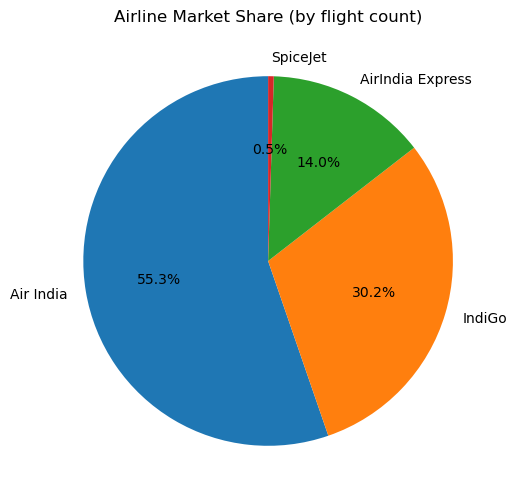

In [43]:
air_counts = flight_data['Airline'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(air_counts.values,
        labels=air_counts.index,
        autopct='%1.1f%%',
        startangle=90)
plt.title('Airline Market Share (by flight count)')
plt.show()


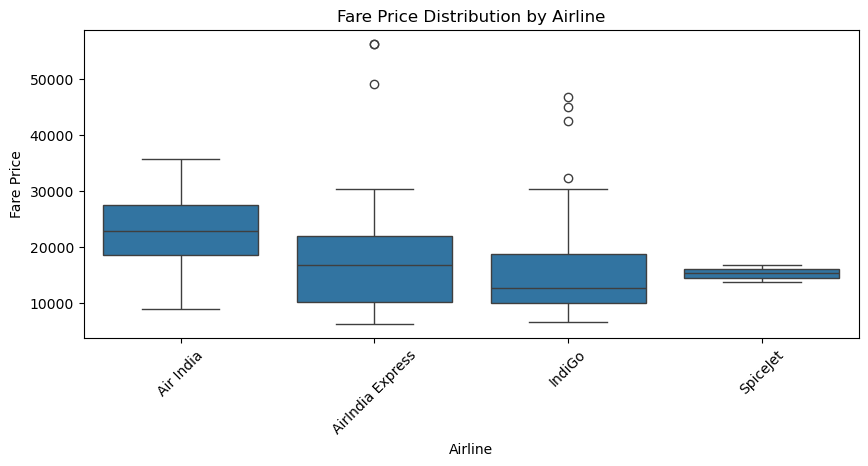

In [44]:
plt.figure(figsize=(10,4))
sns.boxplot(data=flight_data, x='Airline', y='Fare Price')
plt.xticks(rotation=45)
plt.title('Fare Price Distribution by Airline')
plt.show()

In [45]:
hours = flight_data['Duration'].str.extract(r'(\d+)h', expand=False).astype(float).fillna(0)
mins  = flight_data['Duration'].str.extract(r'(\d+)m', expand=False).astype(float).fillna(0)

flight_data['Duration_min'] = hours * 60 + mins


C:\Users\shiva kumar\AppData\Local\Temp\ipykernel_8212\3569609649.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data['Duration_min'] = hours * 60 + mins


In [47]:
# Remove non‑numeric characters and convert to float
flight_data['Checked Baggage'] = (flight_data['Checked Baggage'].str.extract(r'(\d+\.?\d*)', expand=False))   # keep number part.astype(float))

flight_data['Hand Baggage'] = (flight_data['Hand Baggage'].str.extract(r'(\d+\.?\d*)', expand=False).astype(float))


C:\Users\shiva kumar\AppData\Local\Temp\ipykernel_8212\2884596341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data['Checked Baggage'] = (flight_data['Checked Baggage'].str.extract(r'(\d+\.?\d*)', expand=False))   # keep number part.astype(float))
C:\Users\shiva kumar\AppData\Local\Temp\ipykernel_8212\2884596341.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data['Hand Baggage'] = (flight_data['Hand Baggage'].str.extract(r'(\d+\.?\d*)', expand=False).astype(float))


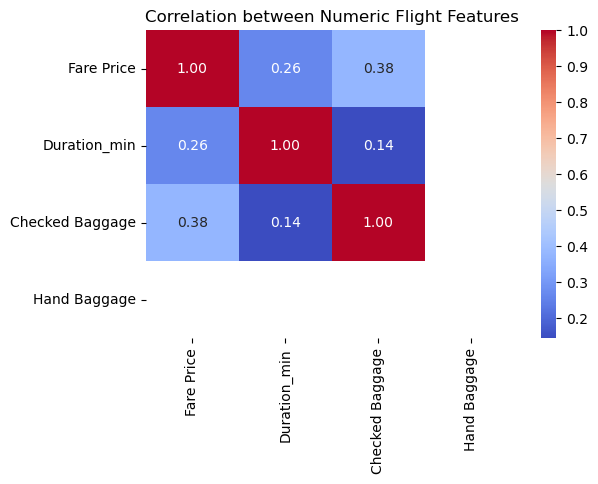

In [48]:
num_cols = ['Fare Price', 'Duration_min', 'Checked Baggage', 'Hand Baggage']
corr = flight_data[num_cols].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Numeric Flight Features')
plt.show()


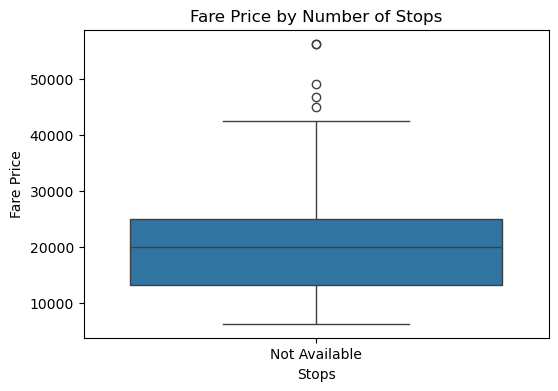

In [49]:
plt.figure(figsize=(6,4))
sns.boxplot(data=flight_data, x='Stops', y='Fare Price')
plt.title('Fare Price by Number of Stops')
plt.show()


C:\Users\shiva kumar\AppData\Local\Temp\ipykernel_8212\761933609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data['Dep_Hour'] = pd.to_datetime(flight_data['Departure Time']).dt.hour


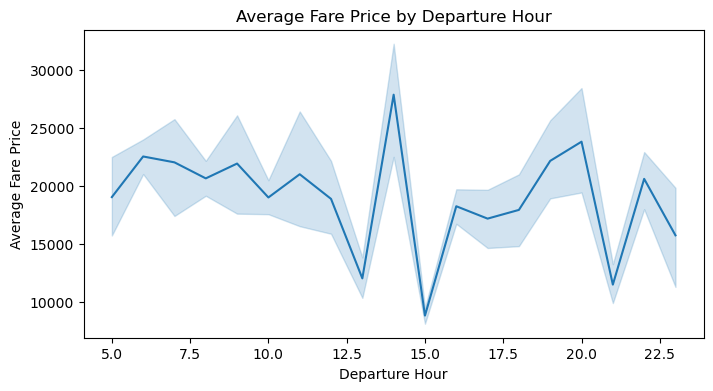

In [50]:
flight_data['Dep_Hour'] = pd.to_datetime(flight_data['Departure Time']).dt.hour

plt.figure(figsize=(8,4))
sns.lineplot(data=flight_data, x='Dep_Hour', y='Fare Price', estimator='mean')
plt.title('Average Fare Price by Departure Hour')
plt.xlabel('Departure Hour')
plt.ylabel('Average Fare Price')
plt.show()


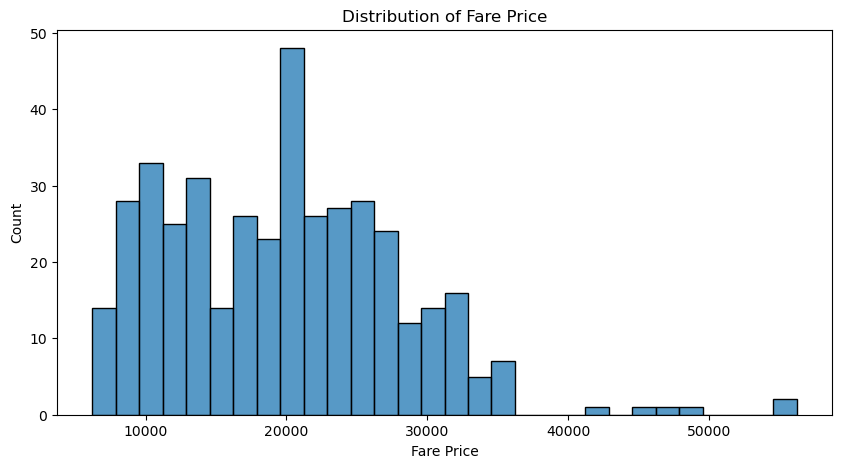

In [51]:
plt.figure(figsize=(10,5))
sns.histplot(data=flight_data, x='Fare Price', bins=30) # adjust bins as needed
plt.title('Distribution of Fare Price')
plt.show()

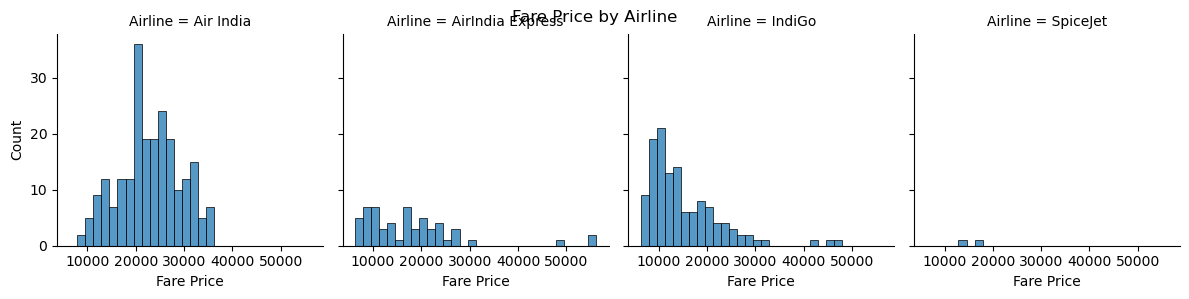

In [30]:
sns.displot(data=flight_data, x='Fare Price', col='Airline', col_wrap=4, bins=30, height=3)
plt.subplots_adjust(top=0.9)
plt.suptitle('Fare Price by Airline')
plt.show()

In [31]:
flight_data

,Airline,Flight Number,Departure City,Departure Time,Arrival City,Arrival Time,Duration,Stops,Fare Type,Fare Price,...,Date Change Policy,Seat Selection,Checked Baggage,Hand Baggage,Meal,Dep_Day,Dep_Month,Dep_Year,Dep_Weekday,Duration_min
2,IndiGo,6E-849,Hyderabad(HYD),2026-01-04 15:15:00,New Delhi(DEL),2026-01-04 17:50:00,2h 35m,Not Available,Saver Fare,8009.0,...,Yes,Standard: Chargeable\nXL seats: Chargeable,15 Kgs,7 Kgs,Chargeable,4,1,2026,6,155.0
3,IndiGo,6E-849,Hyderabad(HYD),2026-01-04 15:15:00,New Delhi(DEL),2026-01-04 17:50:00,2h 35m,Not Available,Flexi Plus,8534.0,...,Yes,Standard: FREE\nXL seats: Chargeable,15 Kgs,7 Kgs,Complimentary,4,1,2026,6,155.0
4,IndiGo,6E-849,Hyderabad(HYD),2026-01-04 15:15:00,New Delhi(DEL),2026-01-04 17:50:00,2h 35m,Not Available,Super 6E,9584.0,...,Yes,Standard: FREE\nXL seats: FREE,20 Kg,7 Kgs,Complimentary,4,1,2026,6,155.0
6,IndiGo,6E-962,Hyderabad(HYD),2026-01-04 17:00:00,New Delhi(DEL),2026-01-04 19:20:00,2h 20m,Not Available,Saver Fare,8009.0,...,Yes,Standard: Chargeable\nXL seats: Chargeable,15 Kgs,7 Kgs,Chargeable,4,1,2026,6,140.0
7,IndiGo,6E-962,Hyderabad(HYD),2026-01-04 17:00:00,New Delhi(DEL),2026-01-04 19:20:00,2h 20m,Not Available,Flexi Plus,8534.0,...,Yes,Standard: FREE\nXL seats: Chargeable,15 Kgs,7 Kgs,Complimentary,4,1,2026,6,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,AirIndia Express,IX-2941/IX-1970,Hyderabad(HYD),2026-01-04 20:00:00,Ghaziabad(HDO),2026-01-04 08:15:00,12h 15m,Not Available,Classic,17981.0,...,Yes,Standard: Chargeable\nPrime: Chargeable,15 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Free,4,1,2026,6,735.0
544,AirIndia Express,IX-2941/IX-1970,Hyderabad(HYD),2026-01-04 20:00:00,Ghaziabad(HDO),2026-01-04 08:15:00,12h 15m,Not Available,Flex,18821.0,...,Yes,Standard: Chargeable\nPrime: Chargeable,20 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Free,4,1,2026,6,735.0
546,AirIndia Express,IX-1072/IX-1970,Hyderabad(HYD),2026-01-04 22:15:00,Ghaziabad(HDO),2026-01-04 08:15:00,10h 00m,Not Available,Value,21864.0,...,Yes,Standard: Chargeable\nPrime: Chargeable,15 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Chargeable,4,1,2026,6,600.0
547,AirIndia Express,IX-1072/IX-1970,Hyderabad(HYD),2026-01-04 22:15:00,Ghaziabad(HDO),2026-01-04 08:15:00,10h 00m,Not Available,Classic,22284.0,...,Yes,Standard: Chargeable\nPrime: Chargeable,15 Kgs,7 Kgs,Hot Meal: Chargeable\nLite Bite: Free,4,1,2026,6,600.0


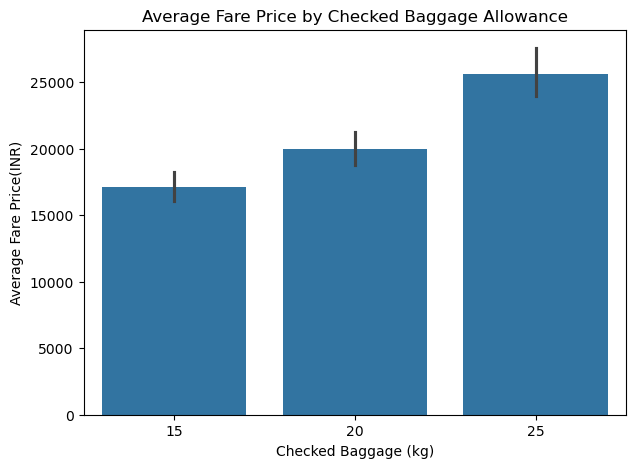

In [55]:
plt.figure(figsize=(7,5))
sns.barplot(data=flight_data, x='Checked Baggage', y = 'Fare Price',estimator = 'mean') # adjust bins as needed
plt.title('Average Fare Price by Checked Baggage Allowance')
plt.xlabel('Checked Baggage (kg)')
plt.ylabel('Average Fare Price(INR)')
plt.show()

C:\Users\shiva kumar\AppData\Local\Temp\ipykernel_8212\1471139134.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('Airline')['Fare Price']


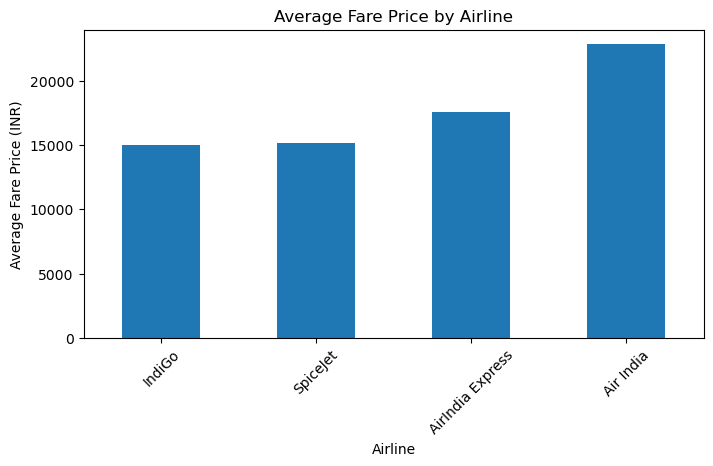

In [57]:
airline_avg = (
    flight_data
    .groupby('Airline')['Fare Price']
    .mean()
    .sort_values()
)

plt.figure(figsize=(8,4))
airline_avg.plot(kind='bar')
plt.title('Average Fare Price by Airline')
plt.ylabel('Average Fare Price (INR)')
plt.xlabel('Airline')
plt.xticks(rotation=45)
plt.show()
